<a href="https://colab.research.google.com/github/Agbropro/Agbropro/blob/main/alvori.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Dependencies

In [ ]:
!python --version

Python 3.10.12


In [ ]:
!pip install -r '/content/drive/MyDrive/Alvori-Collab/alvori_ecg_vit-main/requirements.txt'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.3/52.3 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.5/138.5 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.4/58.4 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.3/57.3 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.5/47.5 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.6/124.6 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.6/80.6 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.0/60.0 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 30.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.9/160.9 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1

# Connect Cloud

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install imblearn

In [ ]:
path = "/content/drive/MyDrive/Alvori-Collab/a-large-scale-12-lead-electrocardiogram-database-for-arrhythmia-study-1.0.0"

In [ ]:
!ls /content/drive/MyDrive/Alvori-Collab/a-large-scale-12-lead-electrocardiogram-database-for-arrhythmia-study-1.0.0

ConditionNames_SNOMED-CT.csv  LICENSE.txt  RECORDS  SHA256SUMS.txt  WFDBRecords


# Dataset Description

**A large scale 12-lead electrocardiogram database for arrhythmia study**


*   12 Lead ECG Data
*   45,152 patients
*   500 Hz Sampling Frequency
*   10 seconds recording period
*   Amplitudes in Microvolts
*   46 Folders, 10 subfolders each, 100 files (.hea and .mat) in each subfolders
*   Per data has 5000 rows and 12 columns (ECG Lead)





## Reading Dataset

In [ ]:
from pathlib import Path
from zlib import crc32

import numpy as np
import pandas as pd
import tensorflow as tf
import wfdb
from tqdm import tqdm


def read_record(path):
    record = wfdb.rdrecord(path.decode("utf-8"))
    return record.p_signal.astype(np.float32)


def ds_base(df, shuffle, bs):
    ds = tf.data.Dataset.from_tensor_slices((df["file"], list(df["y"])))
    if shuffle:
        ds = ds.shuffle(len(df))
    ds = ds.map(
        lambda x, y: (tf.numpy_function(read_record, inp=[x], Tout=tf.float32), y),
        num_parallel_calls=tf.data.AUTOTUNE,
        deterministic=False,
    )
    ds = ds.map(lambda x, y: (tf.where(tf.math.is_nan(x), tf.zeros_like(x), x), y))  # replace nan with zero
    # truncate from 12 to 6
    ds = ds.map(lambda x, y: (x[:, :6], y))
    ds = ds.map(lambda x, y: (tf.ensure_shape(x, [5000, 6]), y))
    ds = ds.batch(bs)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds


def gen_datasets(df: pd.DataFrame, bs: int):
    train_ds = ds_base(df[~df["test"]], True, bs)
    val_ds = ds_base(df[df["test"]], False, bs)
    return train_ds, val_ds


def gen_df(database_root: Path, test_ratio=0.2):
    # 59118001 -> RBBB
    # 89792004 -> RVH
    labels = [59118001, 89792004]
    labels_index = {snomed: i for i, snomed in enumerate(labels)}
    records = []
    failed = []
    for i in tqdm(list(database_root.glob("**/*.hea"))):
        file = i.with_suffix("").as_posix()
        try:
            record = wfdb.rdrecord(file)
        except Exception:
            failed.append(file)
            continue

        metadata = dict([i.split(": ") for i in record.comments])
        y = np.zeros(len(labels_index))
        if "Dx" in metadata:
            snomeds = map(int, metadata["Dx"].split(","))
            indices = [labels_index[i] for i in snomeds if i in labels_index]
            y[indices] = 1
        records.append({"file": file, "y": y})
        # if i == 50:
        #     break

    n_sample = 20000
    # n_sample = int(0.4 * 50)
    df = pd.DataFrame(records)
    df = pd.concat(
        [df[df["y"].apply(lambda y: np.sum(y) == 0)].sample(n_sample), df[df["y"].apply(lambda y: np.sum(y) != 0)]]
    )
    df["test"] = df["file"].apply(lambda file: crc32(bytes(file, "utf-8")) < test_ratio * 2**32)
    return df


In [ ]:
from pathlib import Path
import numpy as np
import pandas as pd
import wfdb
from tqdm import tqdm


def collect_data(database_root: Path):
    """
    Collects ECG data file paths and their associated labels into a DataFrame.

    Args:
        database_root (Path): The root directory where ECG `.hea` files are stored.

    Returns:
        pd.DataFrame: A DataFrame with two columns:
                      - 'file': Path to the ECG record.
                      - 'label': One-hot encoded labels for each record.
    """
    # Define labels of interest (for example, using SNOMED codes)
    labels = [59118001, 89792004]  # RBBB and RVH, can be modified as needed
    labels_index = {snomed: i for i, snomed in enumerate(labels)}

    records = []

    # Iterate over each `.hea` file in the directory
    for file in tqdm(list(database_root.glob("**/*.hea"))):
        file_path = file.with_suffix("").as_posix()

        try:
            # Read the .hea file to extract metadata
            record = wfdb.rdrecord(file_path)
            metadata = dict([item.split(": ") for item in record.comments])
        except Exception as e:
            print(f"Failed to read file {file_path}: {e}")
            continue

        # Create a zeroed label array with the length of labels
        y = np.zeros(len(labels_index), dtype=int)

        # Set label if diagnostic code is present in metadata
        if "Dx" in metadata:
            snomeds = map(int, metadata["Dx"].split(","))
            for snomed_code in snomeds:
                if snomed_code in labels_index:
                    y[labels_index[snomed_code]] = 1

        # Append the record file path and label to the records list
        records.append({"file": file_path, "label": y})

    # Convert records to a DataFrame
    df = pd.DataFrame(records)
    return df


# Train Model

## Stratify - Val

In [ ]:
from pathlib import Path
import numpy as np
import pandas as pd
import wfdb
from tqdm import tqdm


In [ ]:
balanced_df = pd.read_csv(r'/content/drive/MyDrive/Alvori-Collab/processed_data/balanced_df.csv')

In [ ]:
balanced_df

/usr/local/lib/python3.10/dist-packages/google/colab/_interactive_table_hint_button.py:178: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  df_html=dataframe._repr_html_(),  # pylint: disable=protected-access


,Unnamed: 0,file,label
0,11248,D:/Job/Proyek/Alvori/alvori_ecg_vit-main/a-lar...,SB
1,16480,D:/Job/Proyek/Alvori/alvori_ecg_vit-main/a-lar...,AF
2,14016,D:/Job/Proyek/Alvori/alvori_ecg_vit-main/a-lar...,AF
3,31134,D:/Job/Proyek/Alvori/alvori_ecg_vit-main/a-lar...,SB
4,11641,D:/Job/Proyek/Alvori/alvori_ecg_vit-main/a-lar...,SB
...,...,...,...
267,44277,D:/Job/Proyek/Alvori/alvori_ecg_vit-main/a-lar...,RVH
268,44278,D:/Job/Proyek/Alvori/alvori_ecg_vit-main/a-lar...,RVH
269,44285,D:/Job/Proyek/Alvori/alvori_ecg_vit-main/a-lar...,RVH
270,44677,D:/Job/Proyek/Alvori/alvori_ecg_vit-main/a-lar...,RVH


In [ ]:
balanced_rec = pd.read_pickle(r'/content/drive/MyDrive/Alvori-Collab/processed_data/ecg_pickle.pkl')

In [ ]:
X= np.array(balanced_rec['ecg_data'].to_list())

In [ ]:
import tensorflow as tf
X_reshaped = X.reshape((-1, 5000, 12))
balanced_df['encoded_label'] = balanced_df['label'].map({'RBBB': 1, 'RVH': 2}).fillna(0).astype(int)
y = balanced_df['encoded_label']
y_one_hot = tf.keras.utils.to_categorical(y, num_classes=3)


In [ ]:
X_reshaped_2 = X.reshape((-1, 12,5000))

In [ ]:
y_one_hot.shape

(272, 3)

### Shape -1 5000 12

In [ ]:
from sklearn.model_selection import train_test_split

# First, split into training+validation and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_reshaped, y_one_hot, test_size=0.2, random_state=42, stratify=y_one_hot
)

# Next, split the training+validation set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val
)

# Print the sizes of the splits
print(f"Train set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")


Train set size: 162
Validation set size: 55
Test set size: 55


### Shape Explore

Analisis Shape ECG yang sudah dikumpulkan, berupa 12 channel lead ECG sebagai kolom dan 5000 baris. Data ini digunakan untuk eksplorasi data dan tidak bisa digunakan untuk training deep learning karena bentuk data yang tidak sesuai

In [ ]:
from sklearn.model_selection import train_test_split

# First, split into training+validation and test sets
X_train_val2, X_test2, y_train_val2, y_test2 = train_test_split(
    X_reshaped, y_one_hot, test_size=0.2, random_state=42
)

# Next, split the training+validation set into training and validation sets
X_train2, X_val2, y_train2, y_val2 = train_test_split(
    X_train_val2, y_train_val2, test_size=0.25, random_state=42
)

# Print the sizes of the splits
print(f"Train set size: {X_train2.shape[0]}")
print(f"Validation set size: {X_val2.shape[0]}")
print(f"Test set size: {X_test2.shape[0]}")


Train set size: 162
Validation set size: 55
Test set size: 55


In [ ]:
y_train_val_decode = np.argmax(y_train_val, axis=1)
y_train_val_decode2 = np.argmax(y_train_val2, axis=1)

In [ ]:
split_df = pd.DataFrame({'no_stratify':y_train_val_decode2,'stratify':y_train_val_decode})

In [ ]:
count_nostrat = split_df['no_stratify'].value_counts().reset_index()
count_strat = split_df['stratify'].value_counts().reset_index()

In [ ]:
count_strat

/usr/local/lib/python3.10/dist-packages/google/colab/_interactive_table_hint_button.py:178: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  df_html=dataframe._repr_html_(),  # pylint: disable=protected-access
/usr/local/lib/python3.10/dist-packages/google/colab/_interactive_table_hint_button.py:178: FutureWarning: RangeIndex.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  df_html=dataframe._repr_html_(),  # pylint: disable=protected-access


,stratify,count
0,0,108
1,2,72
2,1,37


In [ ]:
count_nostrat

/usr/local/lib/python3.10/dist-packages/google/colab/_interactive_table_hint_button.py:178: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  df_html=dataframe._repr_html_(),  # pylint: disable=protected-access
/usr/local/lib/python3.10/dist-packages/google/colab/_interactive_table_hint_button.py:178: FutureWarning: RangeIndex.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  df_html=dataframe._repr_html_(),  # pylint: disable=protected-access


,no_stratify,count
0,0,107
1,2,72
2,1,38


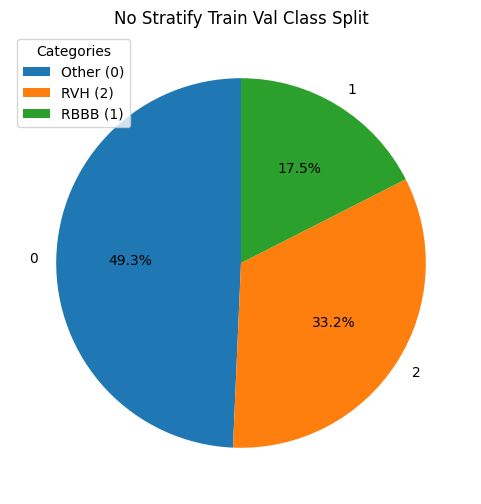

In [ ]:
# Create a pie chart
import matplotlib.pyplot as plt
legend_labels = ['Other (0)', 'RVH (2)', 'RBBB (1)']
plt.figure(figsize=(6, 6))
plt.pie(count_nostrat['count'], labels=count_nostrat['no_stratify'], autopct='%1.1f%%', startangle=90)
plt.title('No Stratify Train Val Class Split')
plt.legend(legend_labels, title="Categories")
plt.show()

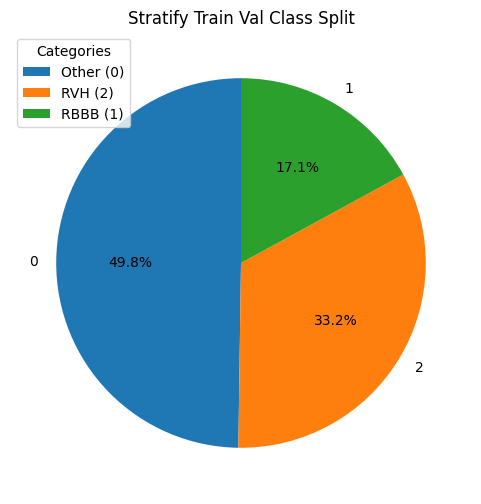

In [ ]:
# Create a pie chart
import matplotlib.pyplot as plt
legend_labels = ['Other (0)', 'RVH (2)', 'RBBB (1)']
plt.figure(figsize=(6, 6))
plt.pie(count_strat['count'], labels=count_strat['stratify'], autopct='%1.1f%%', startangle=90)
plt.title('Stratify Train Val Class Split')
plt.legend(legend_labels, title="Categories")
plt.show()

In [ ]:
split_df['stratify'].value_counts()

,count
stratify,
0,108
2,72
1,37


### VIT TRANSFORMER

In [ ]:
import tensorflow as tf
import tensorflow_addons as tfa
class ViTEmbeddings(tf.keras.layers.Layer):
    def __init__(self, patch_size, hidden_size, dropout=0.0, **kwargs):
        super().__init__(**kwargs)

        self.patch_size = patch_size
        self.hidden_size = hidden_size

        self.patch_embeddings = tf.keras.layers.Conv1D(filters=hidden_size, kernel_size=patch_size, strides=patch_size)
        self.dropout = tf.keras.layers.Dropout(rate=dropout)

    def build(self, input_shape):
        self.cls_token = self.add_weight(shape=(1, 1, self.hidden_size), trainable=True, name="cls_token")
        num_patches = input_shape[1] // self.patch_size
        self.position_embeddings = self.add_weight(shape=(1, num_patches + 1, self.hidden_size), trainable=True, name="position_embeddings")

    def call(self, inputs: tf.Tensor, training: bool = False) -> tf.Tensor:
        inputs_shape = tf.shape(inputs)
        embeddings = self.patch_embeddings(inputs, training=training)

        cls_tokens = tf.repeat(self.cls_token, repeats=inputs_shape[0], axis=0)
        embeddings = tf.concat((cls_tokens, embeddings), axis=1)

        embeddings = embeddings + self.position_embeddings
        embeddings = self.dropout(embeddings, training=training)

        return embeddings


class MLP(tf.keras.layers.Layer):
    def __init__(self, mlp_dim, out_dim=None, activation="gelu", dropout=0.0, **kwargs):
        super().__init__(**kwargs)
        self.mlp_dim = mlp_dim
        self.out_dim = out_dim
        self.activation = activation
        self.dropout_rate = dropout

    def build(self, input_shape):
        self.dense1 = tf.keras.layers.Dense(self.mlp_dim)
        self.activation1 = tf.keras.layers.Activation(self.activation)
        self.dropout = tf.keras.layers.Dropout(self.dropout_rate)
        self.dense2 = tf.keras.layers.Dense(input_shape[-1] if self.out_dim is None else self.out_dim)

    def call(self, inputs: tf.Tensor, training: bool = False):
        x = self.dense1(inputs)
        x = self.activation1(x)
        x = self.dropout(x, training=training)
        x = self.dense2(x)
        x = self.dropout(x, training=training)
        return x


class Block(tf.keras.layers.Layer):
    def __init__(self, num_heads, attention_dim, mlp_dim, attention_dropout=0.0, sd_survival_probability=1.0, dropout=0.0, **kwargs):
        super().__init__(**kwargs)
        self.norm_before = tf.keras.layers.LayerNormalization()
        self.attn = tf.keras.layers.MultiHeadAttention(num_heads, attention_dim // num_heads, dropout=attention_dropout)
        self.stochastic_depth = tfa.layers.StochasticDepth(sd_survival_probability)
        self.norm_after = tf.keras.layers.LayerNormalization()
        self.mlp = MLP(mlp_dim=mlp_dim, dropout=dropout)

    def call(self, inputs, training=False):
        x = self.norm_before(inputs, training=training)
        x = self.attn(x, x, training=training)
        x = self.stochastic_depth([inputs, x], training=training)
        x2 = self.norm_after(x, training=training)
        x2 = self.mlp(x2, training=training)
        return self.stochastic_depth([x, x2], training=training)


class VisionTransformer(tf.keras.Model):
    def __init__(self, patch_size, hidden_size, depth, num_heads, mlp_dim, num_classes, dropout=0.0, sd_survival_probability=1.0, **kwargs):
        super().__init__(**kwargs)

        self.embeddings = ViTEmbeddings(patch_size, hidden_size, dropout)
        sd = tf.linspace(1.0, sd_survival_probability, depth)
        self.blocks = [
            Block(num_heads, hidden_size, mlp_dim, sd_survival_probability=(sd[i].numpy().item()), dropout=dropout)
            for i in range(depth)
        ]

        self.norm = tf.keras.layers.LayerNormalization()
        self.head = tf.keras.layers.Dense(num_classes)

    def call(self, inputs: tf.Tensor, training: bool = False) -> tf.Tensor:
        x = self.embeddings(inputs, training=training)
        for block in self.blocks:
            x = block(x, training=training)
        x = self.norm(x)
        x = x[:, 0]  # take only cls_token
        return self.head(x)




## Model Training

In [ ]:
import os
epochs = 100
vit = VisionTransformer(
    patch_size=20,
    hidden_size=768,
    depth=6,
    num_heads=6,
    mlp_dim=256,
    num_classes=balanced_df["encoded_label"].nunique(),
    sd_survival_probability=0.9,
)

optimizer = tf.keras.optimizers.Adam(0.0001)
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = ['accuracy', tf.keras.metrics.AUC(from_logits=True, name="roc_auc")]
vit.compile(optimizer=optimizer, loss=loss, metrics=metrics)

os.makedirs("/content/drive/MyDrive/Alvori-Collab/model-created/models_new/strat_val_model/", exist_ok=True)
cbs = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath="/content/drive/MyDrive/Alvori-Collab/model-created/models_new/strat_val_model/",
        monitor="val_roc_auc",
        save_best_only=True,
        save_weights_only=False,  # Save the full model
        mode="max",
        save_format="tf"  # Use TensorFlow SavedModel format
    )
]




In [ ]:
history = vit.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=epochs,
    batch_size=32,
    callbacks=cbs
)


Epoch 1/100
6/6 [==============================] - ETA: 0s - loss: 1.0777 - accuracy: 0.4938 - roc_auc: 0.6509

6/6 [==============================] - 37s 5s/step - loss: 1.0777 - accuracy: 0.4938 - roc_auc: 0.6509 - val_loss: 0.5794 - val_accuracy: 0.6364 - val_roc_auc: 0.7731
Epoch 2/100
6/6 [==============================] - ETA: 0s - loss: 0.5116 - accuracy: 0.7284 - roc_auc: 0.8383

6/6 [==============================] - 25s 4s/step - loss: 0.5116 - accuracy: 0.7284 - roc_auc: 0.8383 - val_loss: 0.6025 - val_accuracy: 0.6909 - val_roc_auc: 0.7924
Epoch 3/100
6/6 [==============================] - ETA: 0s - loss: 0.3956 - accuracy: 0.8025 - roc_auc: 0.8933

6/6 [==============================] - 26s 5s/step - loss: 0.3956 - accuracy: 0.8025 - roc_auc: 0.8933 - val_loss: 0.4862 - val_accuracy: 0.7455 - val_roc_auc: 0.8412
Epoch 4/100
6/6 [==============================] - 14s 2s/step - loss: 0.3485 - accuracy: 0.7840 - roc_auc: 0.9149 - val_loss: 0.5560 - val_accuracy: 0.6545 - val_roc_auc: 0.8326
Epoch 5/100
6/6 [==============================] - 14s 2s/step - loss: 0.3512 - accuracy: 0.7963 - roc_auc: 0.9170 - val_loss: 0.7479 - val_accuracy: 0.6364 - val_roc_auc: 0.8132
Epoch 6/100
6/6 [==============================] - 14s 2s/step - loss: 0.3099 - accuracy: 0.8148 - roc_auc: 0.9393 - val_loss: 0.6415 - val_accuracy: 0.7091 - val_roc_auc: 0.8348
Epoch 7/100
6/6 [==============================] - 14s 2s/step - loss: 0.2784 - accuracy: 0.8395 - roc_auc: 0.9435 - val_loss: 0.6996 - val_accuracy: 0.6727 - val_roc_auc: 0.8319
Epoch 8/100
6/6 [==============================] - 14s 2s/step - loss: 0.3182 - accuracy: 0.7901 - roc_auc: 0.9351 - 

6/6 [==============================] - 24s 4s/step - loss: 0.2291 - accuracy: 0.8889 - roc_auc: 0.9630 - val_loss: 0.5854 - val_accuracy: 0.7091 - val_roc_auc: 0.8426
Epoch 12/100
6/6 [==============================] - ETA: 0s - loss: 0.2596 - accuracy: 0.8457 - roc_auc: 0.9505

6/6 [==============================] - 25s 5s/step - loss: 0.2596 - accuracy: 0.8457 - roc_auc: 0.9505 - val_loss: 0.5949 - val_accuracy: 0.7455 - val_roc_auc: 0.8567
Epoch 13/100
6/6 [==============================] - 14s 2s/step - loss: 0.2071 - accuracy: 0.8765 - roc_auc: 0.9691 - val_loss: 0.6941 - val_accuracy: 0.7455 - val_roc_auc: 0.8359
Epoch 14/100
6/6 [==============================] - 14s 2s/step - loss: 0.1774 - accuracy: 0.9136 - roc_auc: 0.9774 - val_loss: 0.6540 - val_accuracy: 0.7455 - val_roc_auc: 0.8429
Epoch 15/100
6/6 [==============================] - 14s 2s/step - loss: 0.1747 - accuracy: 0.8951 - roc_auc: 0.9773 - val_loss: 0.7791 - val_accuracy: 0.6909 - val_roc_auc: 0.8239
Epoch 16/100
6/6 [==============================] - 14s 2s/step - loss: 0.1538 - accuracy: 0.8951 - roc_auc: 0.9829 - val_loss: 0.5727 - val_accuracy: 0.7455 - val_roc_auc: 0.8566
Epoch 17/100
6/6 [==============================] - 14s 2s/step - loss: 0.1270 - accuracy: 0.9383 - roc_auc: 0.98

6/6 [==============================] - 25s 5s/step - loss: 0.1149 - accuracy: 0.9321 - roc_auc: 0.9918 - val_loss: 0.6154 - val_accuracy: 0.7455 - val_roc_auc: 0.8664
Epoch 19/100
6/6 [==============================] - 14s 2s/step - loss: 0.1239 - accuracy: 0.9198 - roc_auc: 0.9905 - val_loss: 0.6890 - val_accuracy: 0.7455 - val_roc_auc: 0.8532
Epoch 20/100
6/6 [==============================] - ETA: 0s - loss: 0.0947 - accuracy: 0.9568 - roc_auc: 0.9935

6/6 [==============================] - 24s 4s/step - loss: 0.0947 - accuracy: 0.9568 - roc_auc: 0.9935 - val_loss: 0.6148 - val_accuracy: 0.7455 - val_roc_auc: 0.8801
Epoch 21/100
6/6 [==============================] - 14s 2s/step - loss: 0.0775 - accuracy: 0.9506 - roc_auc: 0.9964 - val_loss: 0.6755 - val_accuracy: 0.7636 - val_roc_auc: 0.8764
Epoch 22/100
6/6 [==============================] - 14s 2s/step - loss: 0.0609 - accuracy: 0.9753 - roc_auc: 0.9977 - val_loss: 0.6044 - val_accuracy: 0.8000 - val_roc_auc: 0.8694
Epoch 23/100
6/6 [==============================] - ETA: 0s - loss: 0.2536 - accuracy: 0.8148 - roc_auc: 0.9580

6/6 [==============================] - 25s 5s/step - loss: 0.2536 - accuracy: 0.8148 - roc_auc: 0.9580 - val_loss: 0.6821 - val_accuracy: 0.7273 - val_roc_auc: 0.8819
Epoch 24/100
6/6 [==============================] - 14s 2s/step - loss: 0.1677 - accuracy: 0.9198 - roc_auc: 0.9839 - val_loss: 0.9073 - val_accuracy: 0.7091 - val_roc_auc: 0.8407
Epoch 25/100
6/6 [==============================] - 14s 2s/step - loss: 0.2885 - accuracy: 0.8765 - roc_auc: 0.9610 - val_loss: 0.6376 - val_accuracy: 0.7818 - val_roc_auc: 0.8748
Epoch 26/100
6/6 [==============================] - 14s 2s/step - loss: 0.2302 - accuracy: 0.9012 - roc_auc: 0.9768 - val_loss: 0.6770 - val_accuracy: 0.7091 - val_roc_auc: 0.8541
Epoch 27/100
6/6 [==============================] - 14s 2s/step - loss: 0.1794 - accuracy: 0.8765 - roc_auc: 0.9790 - val_loss: 0.6206 - val_accuracy: 0.7818 - val_roc_auc: 0.8650
Epoch 28/100
6/6 [==============================] - 14s 2s/step - loss: 0.2039 - accuracy: 0.9074 - roc_auc: 0.97

6/6 [==============================] - 25s 5s/step - loss: 0.0344 - accuracy: 0.9815 - roc_auc: 0.9994 - val_loss: 0.7004 - val_accuracy: 0.7636 - val_roc_auc: 0.8832
Epoch 35/100
6/6 [==============================] - 14s 2s/step - loss: 0.0322 - accuracy: 0.9815 - roc_auc: 0.9995 - val_loss: 0.8480 - val_accuracy: 0.8000 - val_roc_auc: 0.8783
Epoch 36/100
6/6 [==============================] - 14s 2s/step - loss: 0.0197 - accuracy: 0.9877 - roc_auc: 0.9998 - val_loss: 0.9012 - val_accuracy: 0.7818 - val_roc_auc: 0.8722
Epoch 37/100
6/6 [==============================] - ETA: 0s - loss: 0.0164 - accuracy: 1.0000 - roc_auc: 1.0000

6/6 [==============================] - 24s 4s/step - loss: 0.0164 - accuracy: 1.0000 - roc_auc: 1.0000 - val_loss: 0.7489 - val_accuracy: 0.8182 - val_roc_auc: 0.8876
Epoch 38/100
6/6 [==============================] - 14s 2s/step - loss: 0.0158 - accuracy: 0.9938 - roc_auc: 0.9999 - val_loss: 0.8311 - val_accuracy: 0.8000 - val_roc_auc: 0.8711
Epoch 39/100
6/6 [==============================] - 14s 2s/step - loss: 0.0039 - accuracy: 1.0000 - roc_auc: 1.0000 - val_loss: 0.9566 - val_accuracy: 0.7455 - val_roc_auc: 0.8675
Epoch 40/100
6/6 [==============================] - 14s 2s/step - loss: 0.0039 - accuracy: 1.0000 - roc_auc: 1.0000 - val_loss: 0.9846 - val_accuracy: 0.7636 - val_roc_auc: 0.8677
Epoch 41/100
6/6 [==============================] - 14s 2s/step - loss: 0.0026 - accuracy: 1.0000 - roc_auc: 1.0000 - val_loss: 0.9781 - val_accuracy: 0.7818 - val_roc_auc: 0.8696
Epoch 42/100
6/6 [==============================] - 14s 2s/step - loss: 0.0026 - accuracy: 1.0000 - roc_auc: 1.00

Model 1

In [ ]:
loaded_model = tf.keras.models.load_model("/content/drive/MyDrive/Alvori-Collab/model-created/models_new/strat_val_model")

In [ ]:
# Evaluate the model on the test dataset
test_loss, test_accuracy, test_auc = loaded_model.evaluate(X_test, y_test)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test AUC: {test_auc}")


2/2 [==============================] - 4s 1s/step - loss: 0.8090 - accuracy: 0.7455 - roc_auc: 0.8717
Test Loss: 0.8090419173240662
Test Accuracy: 0.7454545497894287
Test AUC: 0.8716529607772827


In [ ]:
y_pred_plot = loaded_model.predict(X_test)

2/2 [==============================] - 3s 1s/step


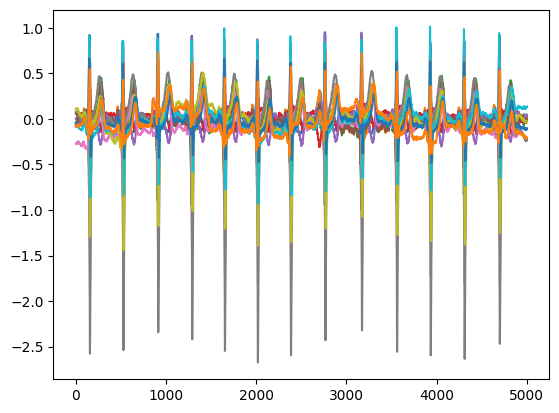

In [ ]:
plt.plot(X_test[0])
plt.show()

In [ ]:
test_loss

0.8090419173240662

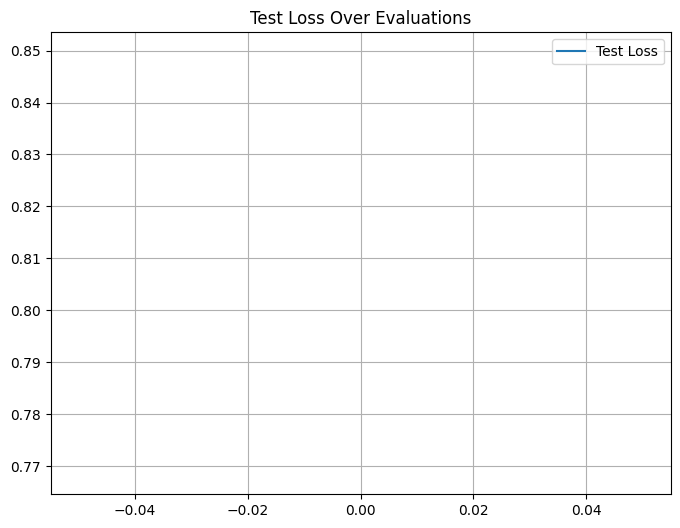

In [ ]:
# You can plot test loss for this evaluation
test_losses = [test_loss]  # List to hold the test loss over different evaluations

# Plotting the loss over evaluations
plt.figure(figsize=(8, 6))
plt.plot(test_losses, label='Test Loss')

# plt.xlabel('Evaluations')
# plt.ylabel('Loss')
plt.title('Test Loss Over Evaluations')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Evaluate the model on the test dataset
test_loss, test_accuracy, test_auc = vit.evaluate(X_test, y_test)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test AUC: {test_auc}")


2/2 [==============================] - 2s 690ms/step - loss: 0.9809 - accuracy: 0.7636 - roc_auc: 0.8917
Test Loss: 0.9809237122535706
Test Accuracy: 0.7636363506317139
Test AUC: 0.8917354345321655


2/2 [==============================] - 2s 690ms/step


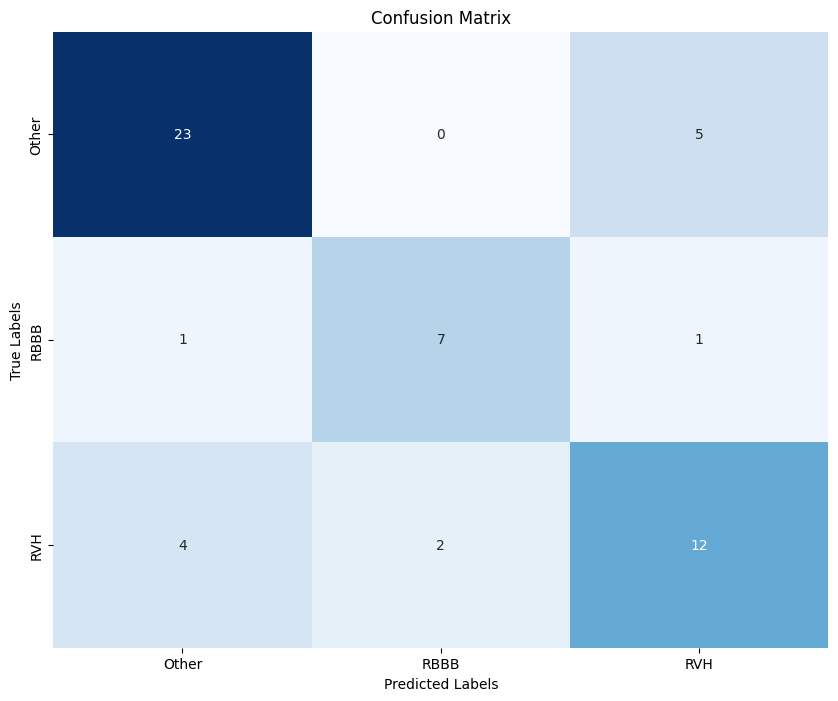

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import tensorflow as tf

# Assuming you already have your trained model and test data
# y_test: true labels
# y_pred: predicted labels

# Get the predictions (if your model is a classification model)
y_pred = vit.predict(X_test)

# For multiclass classification, we need to convert logits to class indices
y_pred_classes = np.argmax(y_pred, axis=-1)
y_true_classes = np.argmax(y_test, axis=-1)  # For one-hot encoded labels

# Calculate the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Create a dictionary for custom class names
class_names = {0: "Other", 1: "RBBB", 2: "RVH"}

# Replace the confusion matrix axis with the class names
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=[class_names.get(i, f"Class {i}") for i in range(cm.shape[1])],
            yticklabels=[class_names.get(i, f"Class {i}") for i in range(cm.shape[0])])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [ ]:
y_test[0]

array([1., 0., 0.], dtype=float32)

In [ ]:
y_pred_class[0]

array([1., 0., 0.])

In [ ]:
# Get predictions on test data
y_pred = vit.predict(X_test)

# If you're dealing with classification, apply a threshold (e.g., 0.5 for binary classification)
y_pred_class = (y_pred > 0.5).astype(float)


2/2 [==============================] - 2s 694ms/step


In [ ]:
# # Calculate accuracy and other metrics if needed
# from sklearn.metrics import accuracy_score, confusion_matrix

# accuracy = accuracy_score(y_test, y_pred_class)
# conf_matrix = confusion_matrix(y_test, y_pred_class)

# print(f"Accuracy: {accuracy}")
# print(f"Confusion Matrix:\n{conf_matrix}")